In [1]:
import uproot as ut
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from uproot3_methods import TLorentzVectorArray
import vector
import awkward as ak
from tqdm import tqdm

import numpy as np

In [2]:
filename = "../signal/NanoAOD/NMSSM_XYH_YToHH_6b_MX_700_MY_400_accstudies_500k_May2021.root:sixBtree"
ttree = ut.open(filename)
branches = ttree.arrays()
nevents = len(ttree['Run'].array())

In [3]:
nevt_mask = lambda n: ak.Array( [True]*n + [False]*(nevents-n) )

In [4]:
def select_jets(branches,variable="jet_ptRegressed",mask=None):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    first6_array = np.argsort(-branches["jet_ptRegressed"][mask]) < 6
    selected_array = np.argsort(-branches[variable][mask])[first6_array]
    return selected_array

In [5]:
sixb_gen_match_mask = branches["nfound_all"] == 6
def select_sixb(branches,mask=None):
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    b_list = ("HX_b1","HX_b2","HY1_b1","HY1_b2","HY2_b1","HY2_b2")
    sixb_index = []
    for event in tqdm(branches[mask],total=ak.sum(mask)):
        sixb_index.append( [event[f"gen_{b}_recojet_index"] for b in b_list if event[f"gen_{b}_recojet_index"] > -1 ] )
    return ak.Array(sixb_index)
def count_sixb(test_selected,sixb_selected):
    return ak.Array( len(set(test).intersection(sixb)) for test,sixb in tqdm(zip(test_selected,sixb_selected)) )
sixb_selected = select_sixb(branches)
nsignal = ak.sum(sixb_gen_match_mask)

100%|██████████| 484002/484002 [00:46<00:00, 10342.23it/s]


In [6]:
pt_selected = select_jets(branches)
sixb_count_pt = count_sixb(pt_selected,sixb_selected)
btag_selected = select_jets(branches,variable="jet_deepJet")
sixb_count_btag = count_sixb(btag_selected,sixb_selected)

signal_pt_selected = select_jets(branches,mask=sixb_gen_match_mask)
signal_btag_selected = select_jets(branches,variable="jet_deepJet",mask=sixb_gen_match_mask)

484002it [00:47, 10130.07it/s]
484002it [00:47, 10276.79it/s]


In [13]:
def plot_simple(variable,branches=branches,mask=None,selected=None,bins=None,xlabel=None,title="No Selection",label=None,figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data = branches[variable][mask]
    if selected is not None: data = branches[variable][mask][selected]
    data = ak.flatten( data,axis=-1 )
    
    ax.hist(data,bins=bins,label=label)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
def plot_mask_comparison(variable,branches=branches,mask=None,selected=None,signal_selected=None,sixb_selected=None
                              ,bins=None,xlabel=None,title="No Selection",label="All Events",figax=None):
    if figax is None: figax = plt.subplots()
    if mask is None: mask = np.ones(ak.size(branches['Run']),dtype=bool)
    (fig,ax) = figax
    
    data1 = branches[variable][mask]
    if selected is not None and "jet_" in variable: data1 = branches[variable][mask][selected]
    data1 = ak.flatten( data1,axis=-1 ); nevts1 = len(data1)
    
    data2 = branches[variable][mask & sixb_gen_match_mask]
    if signal_selected is not None and "jet_" in variable: data2 = branches[variable][mask & sixb_gen_match_mask][signal_selected]
    data2 = ak.flatten( data2,axis=-1 ); nevts2 = len(data2)
    
    data3 = branches[variable][mask & sixb_gen_match_mask]
    if sixb_selected is not None and "jet_" in variable: data3 = branches[variable][mask & sixb_gen_match_mask][sixb_selected[sixb_gen_match_mask]]
    data3 = ak.flatten( data3,axis=-1 ); nevts3 = len(data3)
    
    ax.hist(data1,bins=bins,label=f"{label} ({nevts1:.2e})")
    ax.hist(data2,bins=bins,label=f"Gen Matched Six BJets ({nevts2:.2e})")
    
    if sixb_selected is not None and "jet_" in variable:
        ax.hist(data3,bins=bins,label=f"Signal Six BJets ({nevts3:.2e})",histtype="step",color="black",linewidth=2)
        
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.legend()
    
def presel_study(branches=branches,mask=np.ones(nevents,dtype=bool),
                 selected=None,signal_selected=None,sixb_selected=sixb_selected,sixb_count=None,
                 title="No Selection",tag=""):
    print(f"--- {title} ---")
    varinfo = {
        "njet":{"bins":np.linspace(-0.5,21.5,23),"xlabel":"Number of Jets"},
        f"{tag}jet_ptRegressed":{"bins":np.linspace(0,200,100),"xlabel":"Jet Pt (GeV)"},
        f"{tag}jet_eta":{"bins":np.linspace(-3,3,100),"xlabel":"Jet Eta"},
        f"{tag}jet_phi":{"bins":np.linspace(-3.14,3.14,100),"xlabel":"Jet Phi"},
        f"{tag}jet_deepJet":{"bins":np.linspace(0,1,100),"xlabel":"Jet Btag"},
    }
    fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(25,5))
    mask_evnts = ak.sum(mask)
    signal_evnts= ak.sum(mask & sixb_gen_match_mask)
    
    total_eff = mask_evnts/float(nevents)
    signal_eff = signal_evnts/float(nsignal)
    purity = signal_evnts/float(mask_evnts)
    
    prompt = [
        f"Event Efficiency:  {total_eff:0.2f}",
        f"Signal Efficiency: {signal_eff:0.2f}",
        f"Signal Purity:     {purity:0.2f}"
    ]

    if sixb_count is not None:
        count_list = [ ak.sum(sixb_count == i) for i in range(7) ]
        prompt += [ f"N {i} Signal BJets: {count_list[i]}" for i in range(7) ]
    
    print("\n".join(prompt))
    
    for i,(var,info) in enumerate(varinfo.items()):
        plot_mask_comparison(var,branches=branches,mask=mask,selected=selected,signal_selected=signal_selected,sixb_selected=sixb_selected,title=title,figax=(fig,axs[i]),**info)

--- No Selection ---
Event Efficiency:  1.00
Signal Efficiency: 1.00
Signal Purity:     0.36


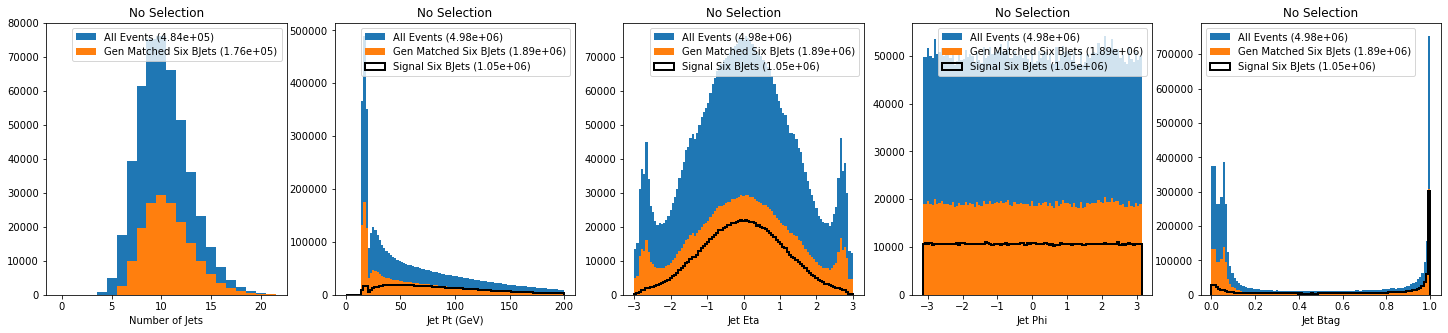

In [9]:
presel_study()

--- 6 Highest Pt Jets ---
Event Efficiency:  1.00
Signal Efficiency: 1.00
Signal Purity:     0.36
N 0 Signal BJets: 3
N 1 Signal BJets: 214
N 2 Signal BJets: 6039
N 3 Signal BJets: 56479
N 4 Signal BJets: 190119
N 5 Signal BJets: 194633
N 6 Signal BJets: 36515


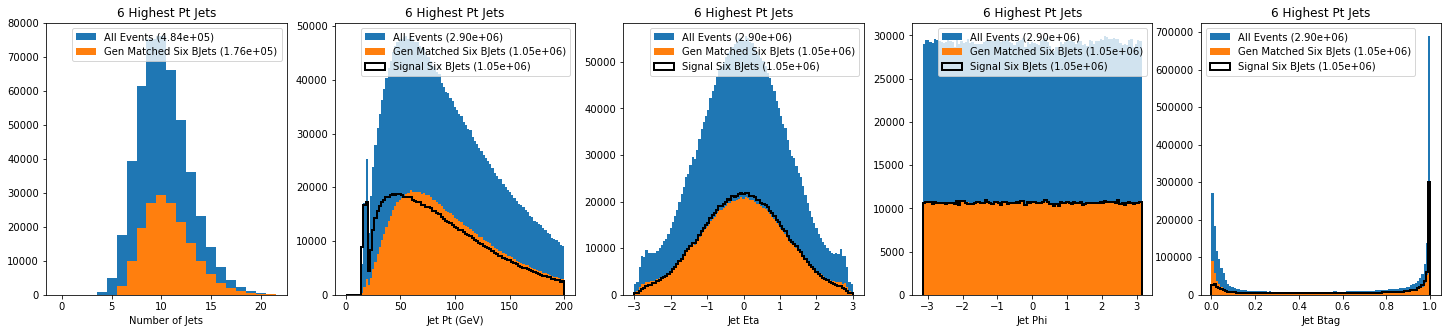

In [14]:
info = {
    "title":"6 Highest Pt Jets",
    "selected":pt_selected,
    "signal_selected":signal_pt_selected,
    "sixb_count":sixb_count_pt
}
presel_study(**info)

--- 6 Highest Btag Jets ---
Event Efficiency:  1.00
Signal Efficiency: 1.00
Signal Purity:     0.36
N 0 Signal BJets: 12
N 1 Signal BJets: 452
N 2 Signal BJets: 7186
N 3 Signal BJets: 50635
N 4 Signal BJets: 161175
N 5 Signal BJets: 202862


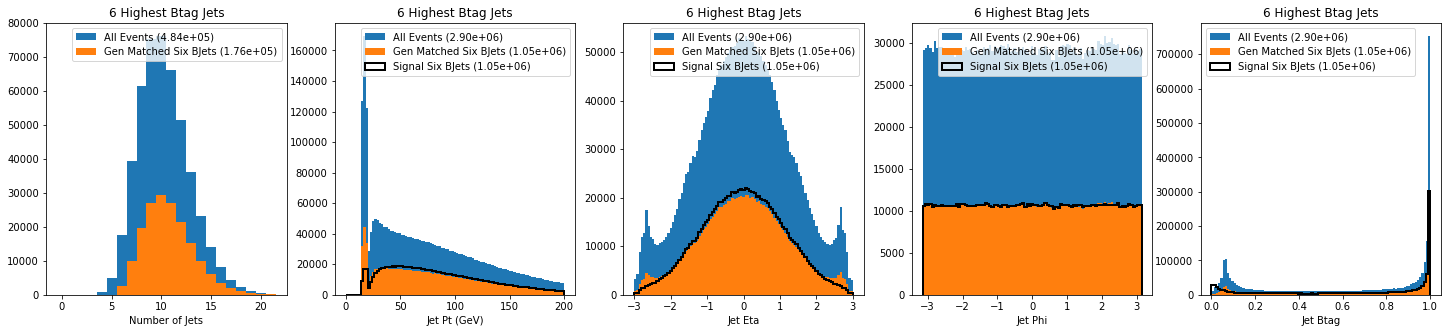

In [12]:
info = {
    "title":"6 Highest Btag Jets",
    "selected":btag_selected,
    "signal_selected":signal_btag_selected,
    "sixb_count":sixb_count_btag
}
presel_study(**info)

In [ ]:
def std_preselection(branches,ptcut=30,etacut=2.4):
    jet_pt_mask = branches["jet_ptRegressed"] > ptcut
    jet_eta_mask = np.abs(branches["jet_eta"]) < etacut
    
    jet_mask = jet_pt_mask & jet_eta_mask
    event_mask = ak.sum(jet_mask,axis=-1) >= 6
    return event_mask
presel_mask = std_preselection(branches)

pt_preselected = select_jets(branches,mask=presel_mask)
btag_preselected = select_jets(branches,variable="jet_deepJet",mask=presel_mask)

signal_pt_preselected = select_jets(branches,mask=presel_mask & sixb_gen_match_mask)
signal_btag_preselected = select_jets(branches,variable="jet_deepJet",mask=presel_mask & sixb_gen_match_mask)

sixb_preselected = select_sixb(branches,mask=presel_mask)

In [ ]:
presel_study(mask=presel_mask,sixb_selected=sixb_preselected,title="STD Preselection")

In [ ]:
presel_study(mask=presel_mask,selected=pt_preselected,signal_selected=signal_pt_preselected,sixb_selected=sixb_preselected,title="STD Preselection 6 Highest Pt")

In [ ]:
presel_study(mask=presel_mask,selected=btag_preselected,signal_selected=signal_btag_preselected,sixb_selected=sixb_preselected,title="STD Preselection 6 Highest Btag")